## Plotting geographic data with Plotly  


In [1]:
import plotly
import geopandas as gpd

We'll use publicly accessible data downloaded from a few locations:
 - Shapefiles will be from the ONS, specifically [here](https://geoportal.statistics.gov.uk/datasets/wards-december-2020-uk-bfc-v2)
 - I'll use public data as a demo for combining geographic datasets from [NOMIS](https://www.nomisweb.co.uk/)

We'll use a shape file to describe the geography, and handily there is the geopandas package which can load them in a fimaliar dataframe format.

In [2]:
geo_data = gpd.read_file('../data/Wards__December_2020__UK_BFC_V2-shp/Wards__December_2020__UK_BFC_V2.shp')

In [3]:
geo_data.head()

,OBJECTID,WD20CD,WD20NM,WD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
0,1,E05000026,Abbey,None,544433,184376,0.081276,51.53981,1.253243e+06,8139.563625,"MULTIPOLYGON (((543581.800 184798.250, 543579...."
1,2,E05000027,Alibon,None,549247,185196,0.150987,51.54592,1.364442e+06,6353.917640,"POLYGON ((549604.103 185773.202, 549613.098 18..."
2,3,E05000028,Becontree,None,546860,185870,0.116869,51.55261,1.292418e+06,6356.336313,"POLYGON ((547563.400 186223.903, 547548.699 18..."
3,4,E05000029,Chadwell Heath,None,548266,189340,0.138596,51.58342,3.384423e+06,9637.038631,"POLYGON ((548880.909 191088.301, 548880.774 19..."
4,5,E05000030,Eastbrook,None,550775,186271,0.173467,51.55518,3.450816e+06,9041.129639,"POLYGON ((551552.951 187362.557, 551553.603 18..."


The geometry column contains the information we'll need to produce maps of the data. Other columns contain information such as the area of the polygons described by the geometry column, and the names given to the regions, which in this example are UK Wards. Geopandas has some built in plotting functions, as pandas does. For example:

<AxesSubplot:>

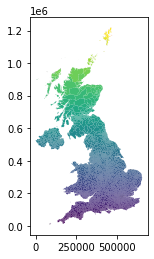

In [4]:
geo_data.plot(column = 'LAT')

However, we want to use plotly in this demonstration to make use of their interactive features. Plotly has a method for making choropleth maps, but it requires more explicitly passing it the geometry.  
First, let's choose a subset of the data to visualise, by just taking a crop in lon/lat. Let's look around Liverpool.

In [5]:
geo_data_subset = geo_data[(geo_data['LAT']>53.3)&(geo_data['LAT']<53.8)&(geo_data['LONG']>-3.2)& (geo_data['LONG']<-2.6)]
cropped = geo_data_subset[['WD20CD', 'LAT']]


<AxesSubplot:>

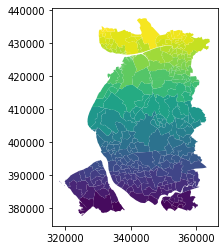

In [6]:
geo_data_subset.plot(column = 'LAT')

For use in the plotly choropleth function, we need our data as a *geojson* not as a shp file - the easiest way to convert the two is to use geopandas. 

In [7]:
geo_data_subset = geo_data_subset.to_crs({"init": "epsg:4326"})
geo_data_subset.to_file('../data/test.geojson', driver="GeoJSON")
geo_data_subset = gpd.read_file('../data/test.geojson',)

/opt/anaconda3/envs/personal/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


It's worth looking at the format of a geojson so the next steps make a bit more sense - it's defined here https://geojson.org/. If you are running this notebook yourself, have a look at the saved file using your text editor. The geopandas function converts the shapefile into the form me need, consisting of a top level "type" of "FeatureCollection" and another "features" entry defining a list of all of the features in the shapefile. Each feature should look similar to those defined by the GeoJSON page.
  
  
There are a few things to take from the form of a GeoJSON. Each entry has a type, a geometry and properties. The **geometry** can be clearly seen in the "geometry" column of the shapefile - each shape we are plotting is defined by a name such as "Polygon", "Multipolygon" etc and a long list of coordinates that define that shape. These column is used by the GeoJSON driver in geopandas to build the GeoJSON. Also of important are the **properties** - every other column in the dataframe is mapped to the properties collection. I found this subtlety to be the main cause of error in getting this to work! For each entry in the feature collection, the "properties" attribute is a dictionary of key value pairs found from the dataframe - this structure will affect which key we pass to the plotly function. Typically, when plotting geographic data, your shapes and the data you wish to use to colour the shapes will be in the same geodataframe, so knowing that in a GeoJSON that they map to a subattribute of the properties attribute will be useful for accessing that data.  
  
You could try and make a file in this format yourself, but I have found geopandas works fine.
  
Alright, let's do a simple visualisation with plotly.

In [9]:
import plotly.express as px

We are using plotly's choropleth function. Refer to their documentation for a fuller description of what is needed, but we pass:
- *cropped* as the dataframe needed - it's from the same place as the geojson, but it could be anything with data we want to show
- *geo_data_subset* as the geojson defining the shapes 
- color = 'LAT' : like in other plotly functions, you name the column of the dataframe (*cropped*) which provides the colours shown in the figure
- locations = 'WD20CD' : which column in the dataframe defines the unique location identifiers
- featureidkey ='properties.WD20CD' : how a feature can be joined to entries in the dataframe. This comes from the GeoJSON shape defined above - the unique identifiers in the dataframe are now in properties for GeoJSON objects
- projection='meractor' geographical projection choice, choose as you prefer!
  
The key action happens in *locations* and *featureidkey*. Knowledge of the format of a GeoJSON is key here - without know we had to pass properties.WD20CD, we would assume to just pass the name of the column as we see it, WD20CD, and the function would fail to map between. Only when we give the correct column for the unique identifiers to connect the shape and the data can we visualise it successfully. 

In [10]:
fig = px.choropleth(cropped, geojson = geo_data_subset, color = 'LAT', locations = 'WD20CD', featureidkey='properties.WD20CD', projection = 'mercator')
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
plotly.offline.plot(fig)

'temp-plot.html'

In [11]:
fig.write_html('../figs/geovis.html')

OK - let's now try and do something slightly more involved and plot data from a different dataset. I'll use the 2011 Census population numbers downloaded from NOMIS. The geographies I am using are 2020 wards - they might not all match up, but as this is just a demonstration I won't worry about that. Your use case might mean you need to make sure you have all wards from the same time. When you download it as a csv, there is an amount of text which gets in the way of using the file at the top and bottom - I have manually removed these before importing.

In [12]:
import pandas as pd
pop_data = pd.read_csv('../data/Population.csv').dropna()
pop_data.head(10)

,2011 ward,2011
1,E05001553 : Bank Top,4032.0
2,E05001554 : Central,4104.0
3,E05001555 : Cockerton East,5385.0
4,E05001556 : Cockerton West,4117.0
5,E05001557 : College,4163.0
6,E05001558 : Eastbourne,6516.0
7,E05001559 : Faverdale,2985.0
8,E05001560 : Harrowgate Hill,5997.0
9,E05001561 : Haughton East,4160.0
10,E05001562 : Haughton North,3341.0


Already we can see the codes need reorganising to be in the same format as those in our shape file - a quick way is to split and save the code and name as separate columns

In [13]:
code = [a.split(' : ')[0] for a in pop_data['2011 ward'].values]
name = [a.split(' : ')[1] for a in pop_data['2011 ward'].values]

In [14]:
pop_data['Code'] = code
pop_data['Name'] = name


Now we can use it with the choropleth function again

In [15]:
fig = px.choropleth(pop_data, geojson = geo_data_subset, color = '2011',hover_name ='Name', locations = 'Code', featureidkey='properties.WD20CD', projection = 'mercator')
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.write_html('../figs/PopulationData.html')

And a few lines to save it for putting in a html file courtesy of [this StackOverflow answer](https://stackoverflow.com/a/38032952/15191702)

In [16]:
string = plotly.offline.plot(fig, include_plotlyjs=False, output_type = 'div')
text_file = open('../data/VizDiv.txt', 'w')
text_file.write(string)
text_file.close()

And we're done!